In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib.patches import Polygon
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial import Voronoi, voronoi_plot_2d

In [25]:
folder = "E:/4D-STEM/ZhouXin/20210812-belta-200kv-In2Se3/20210812 013847-25M-256256/"
EX = np.load(folder + "EX.npy")
EY = np.load(folder + "EY.npy")
ADF = np.load(folder + "ADF.npy")
EX -= np.average(EX)
EY -= np.average(EY)

<ipython-input-33-ae74c52d74de>:10: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
<ipython-input-33-ae74c52d74de>:13: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[1].colorbar(im)
<ipython-input-33-ae74c52d74de>:16: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar impl

Text(0.5, 1.0, 'Experimental STEM')

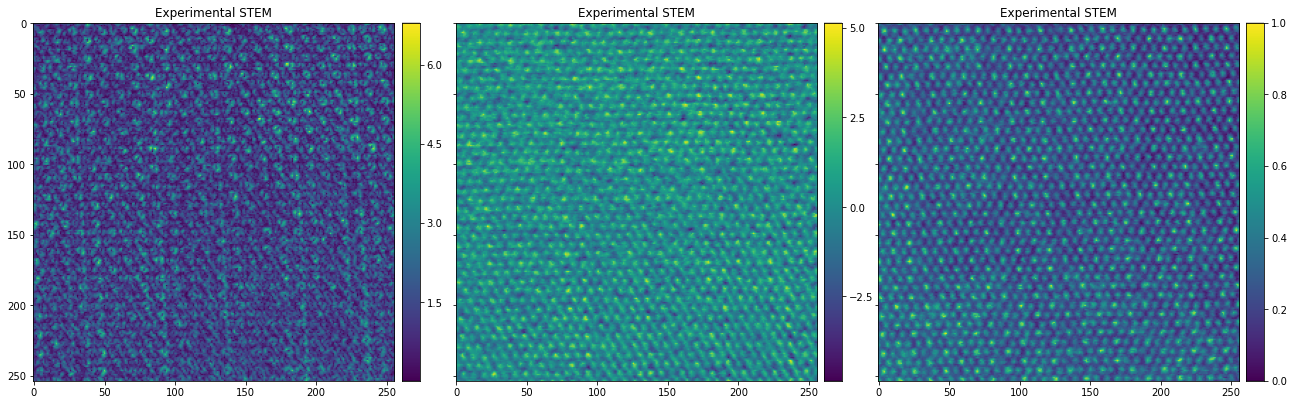

In [33]:
fig =plt.figure(1, figsize=(75, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.sqrt(np.square(EX) + np.square(EY)), cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Experimental STEM")
im=grid[1].imshow(EY, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Experimental STEM")
im=grid[2].imshow(ADF, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Experimental STEM")

In [27]:
#Determine the unit cells first
#refine the averaged template with pixel precison.
def MatchTemplate(I,template,radius,threshold):
    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(radius, radius))
    corr_map = cv2.matchTemplate(I,template,cv2.TM_CCOEFF_NORMED)
    dialated_corr= cv2.dilate(corr_map, kernel)
    peak_idx=np.asarray(np.where((corr_map>= dialated_corr)&(corr_map>threshold))).T
    return corr_map, peak_idx
def RefineTemplate(I,template,radius,threshold):
    corr_map, peak_idx = MatchTemplate(I,template,radius,threshold)
    point_num = peak_idx.shape[0]
    new_template = np.zeros_like(template)
    for i in range(point_num):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        new_template+= I[y_pos:(y_pos+template.shape[0]), x_pos:(x_pos+template.shape[1])]
    new_template/=point_num
    #pick up the maximum from the template.
    max_loc = np.unravel_index(np.argmax(new_template), new_template.shape)
    row_shift = max_loc[0]-int(new_template.shape[0]/2)
    col_shift = max_loc[1]-int(new_template.shape[1]/2)
    peak_idx[:,0] += row_shift
    peak_idx[:,1] += col_shift
    filtered_peak = []
    #generate the tempalte again.
    new_template = np.zeros_like(template)
    for i in range(point_num):
        x_pos = peak_idx[i, 1]
        y_pos = peak_idx[i, 0]
        if (x_pos<0):
            continue
        if (y_pos<0):
            continue
        if (y_pos+template.shape[0]>I.shape[0]):
            continue
        if (x_pos+template.shape[1]>I.shape[1]):
            continue
        filtered_peak.append([y_pos, x_pos])
        new_template+= I[y_pos:(y_pos+template.shape[0]), x_pos:(x_pos+template.shape[1])]
    new_template/=point_num
    filtered_peak = np.asarray(filtered_peak)
    return new_template, corr_map, filtered_peak

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


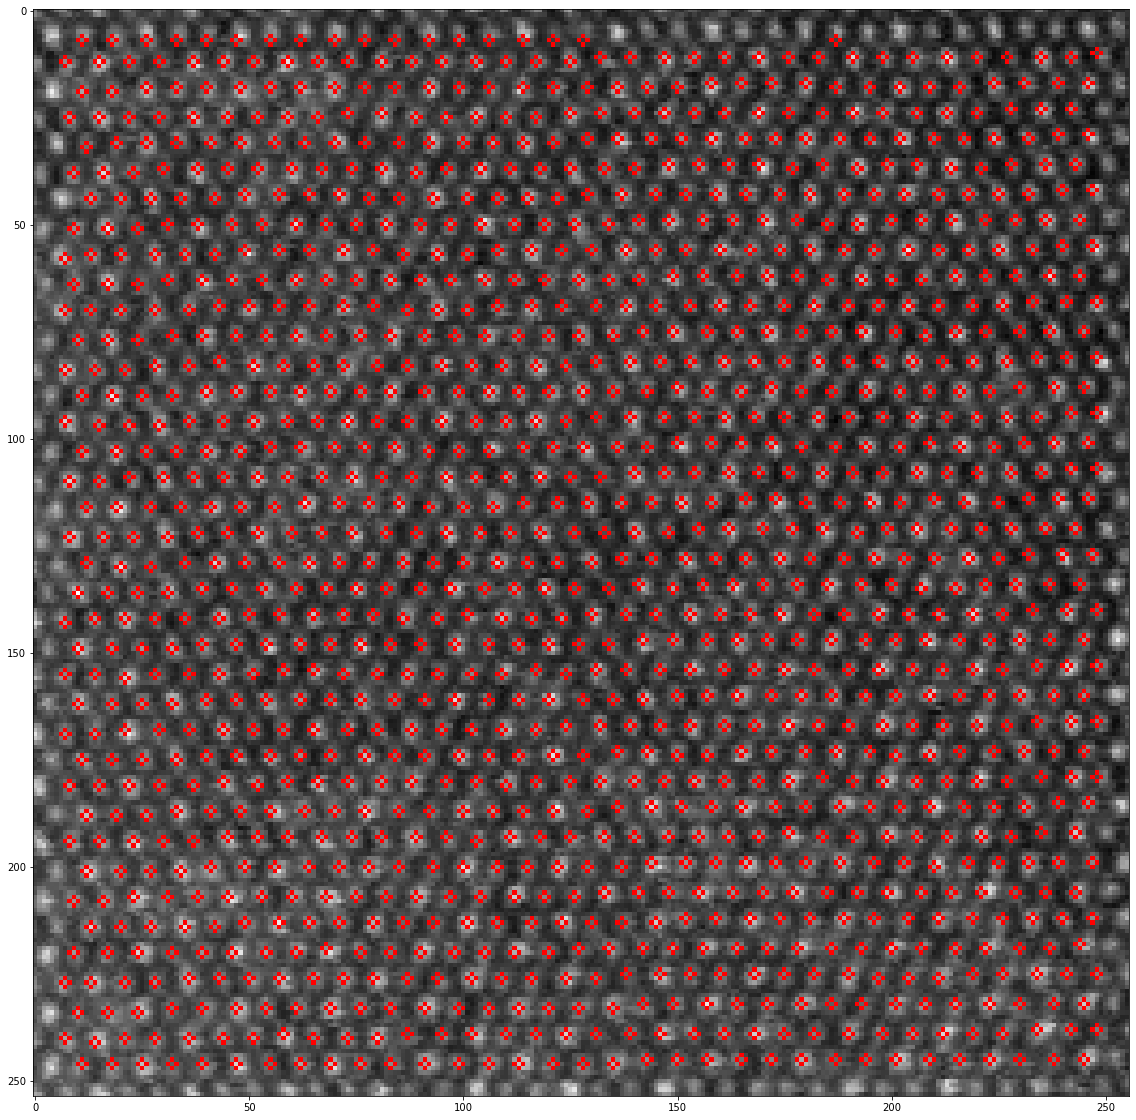

In [28]:
ADF = np.float32((ADF-np.min(ADF))/(np.max(ADF)-np.min(ADF)))
template = ADF[150:165,150:165]
template,corr_coeff, peak_idx=RefineTemplate(ADF, template, 10, 0.3)
rgb_frame=cv2.cvtColor(ADF, cv2.COLOR_GRAY2BGR)
corr_coeff, peak_idx = MatchTemplate(ADF, template, 4, 0.3)
for i in range(0, peak_idx.shape[0]):
    cv2.circle(rgb_frame,(peak_idx[i, 1]+ int(template.shape[1]/2),peak_idx[i, 0]+ int(template.shape[0]/2)),1,(255,0,0))
plt.figure(figsize=(20,20))
plt.imshow(rgb_frame)

In [29]:
ucells = []
for i in range(0, peak_idx.shape[0]):
    ucells.append((peak_idx[i, 1] + int(template.shape[1]/2),peak_idx[i, 0] + int(template.shape[0]/2)))
vor = Voronoi(ucells)

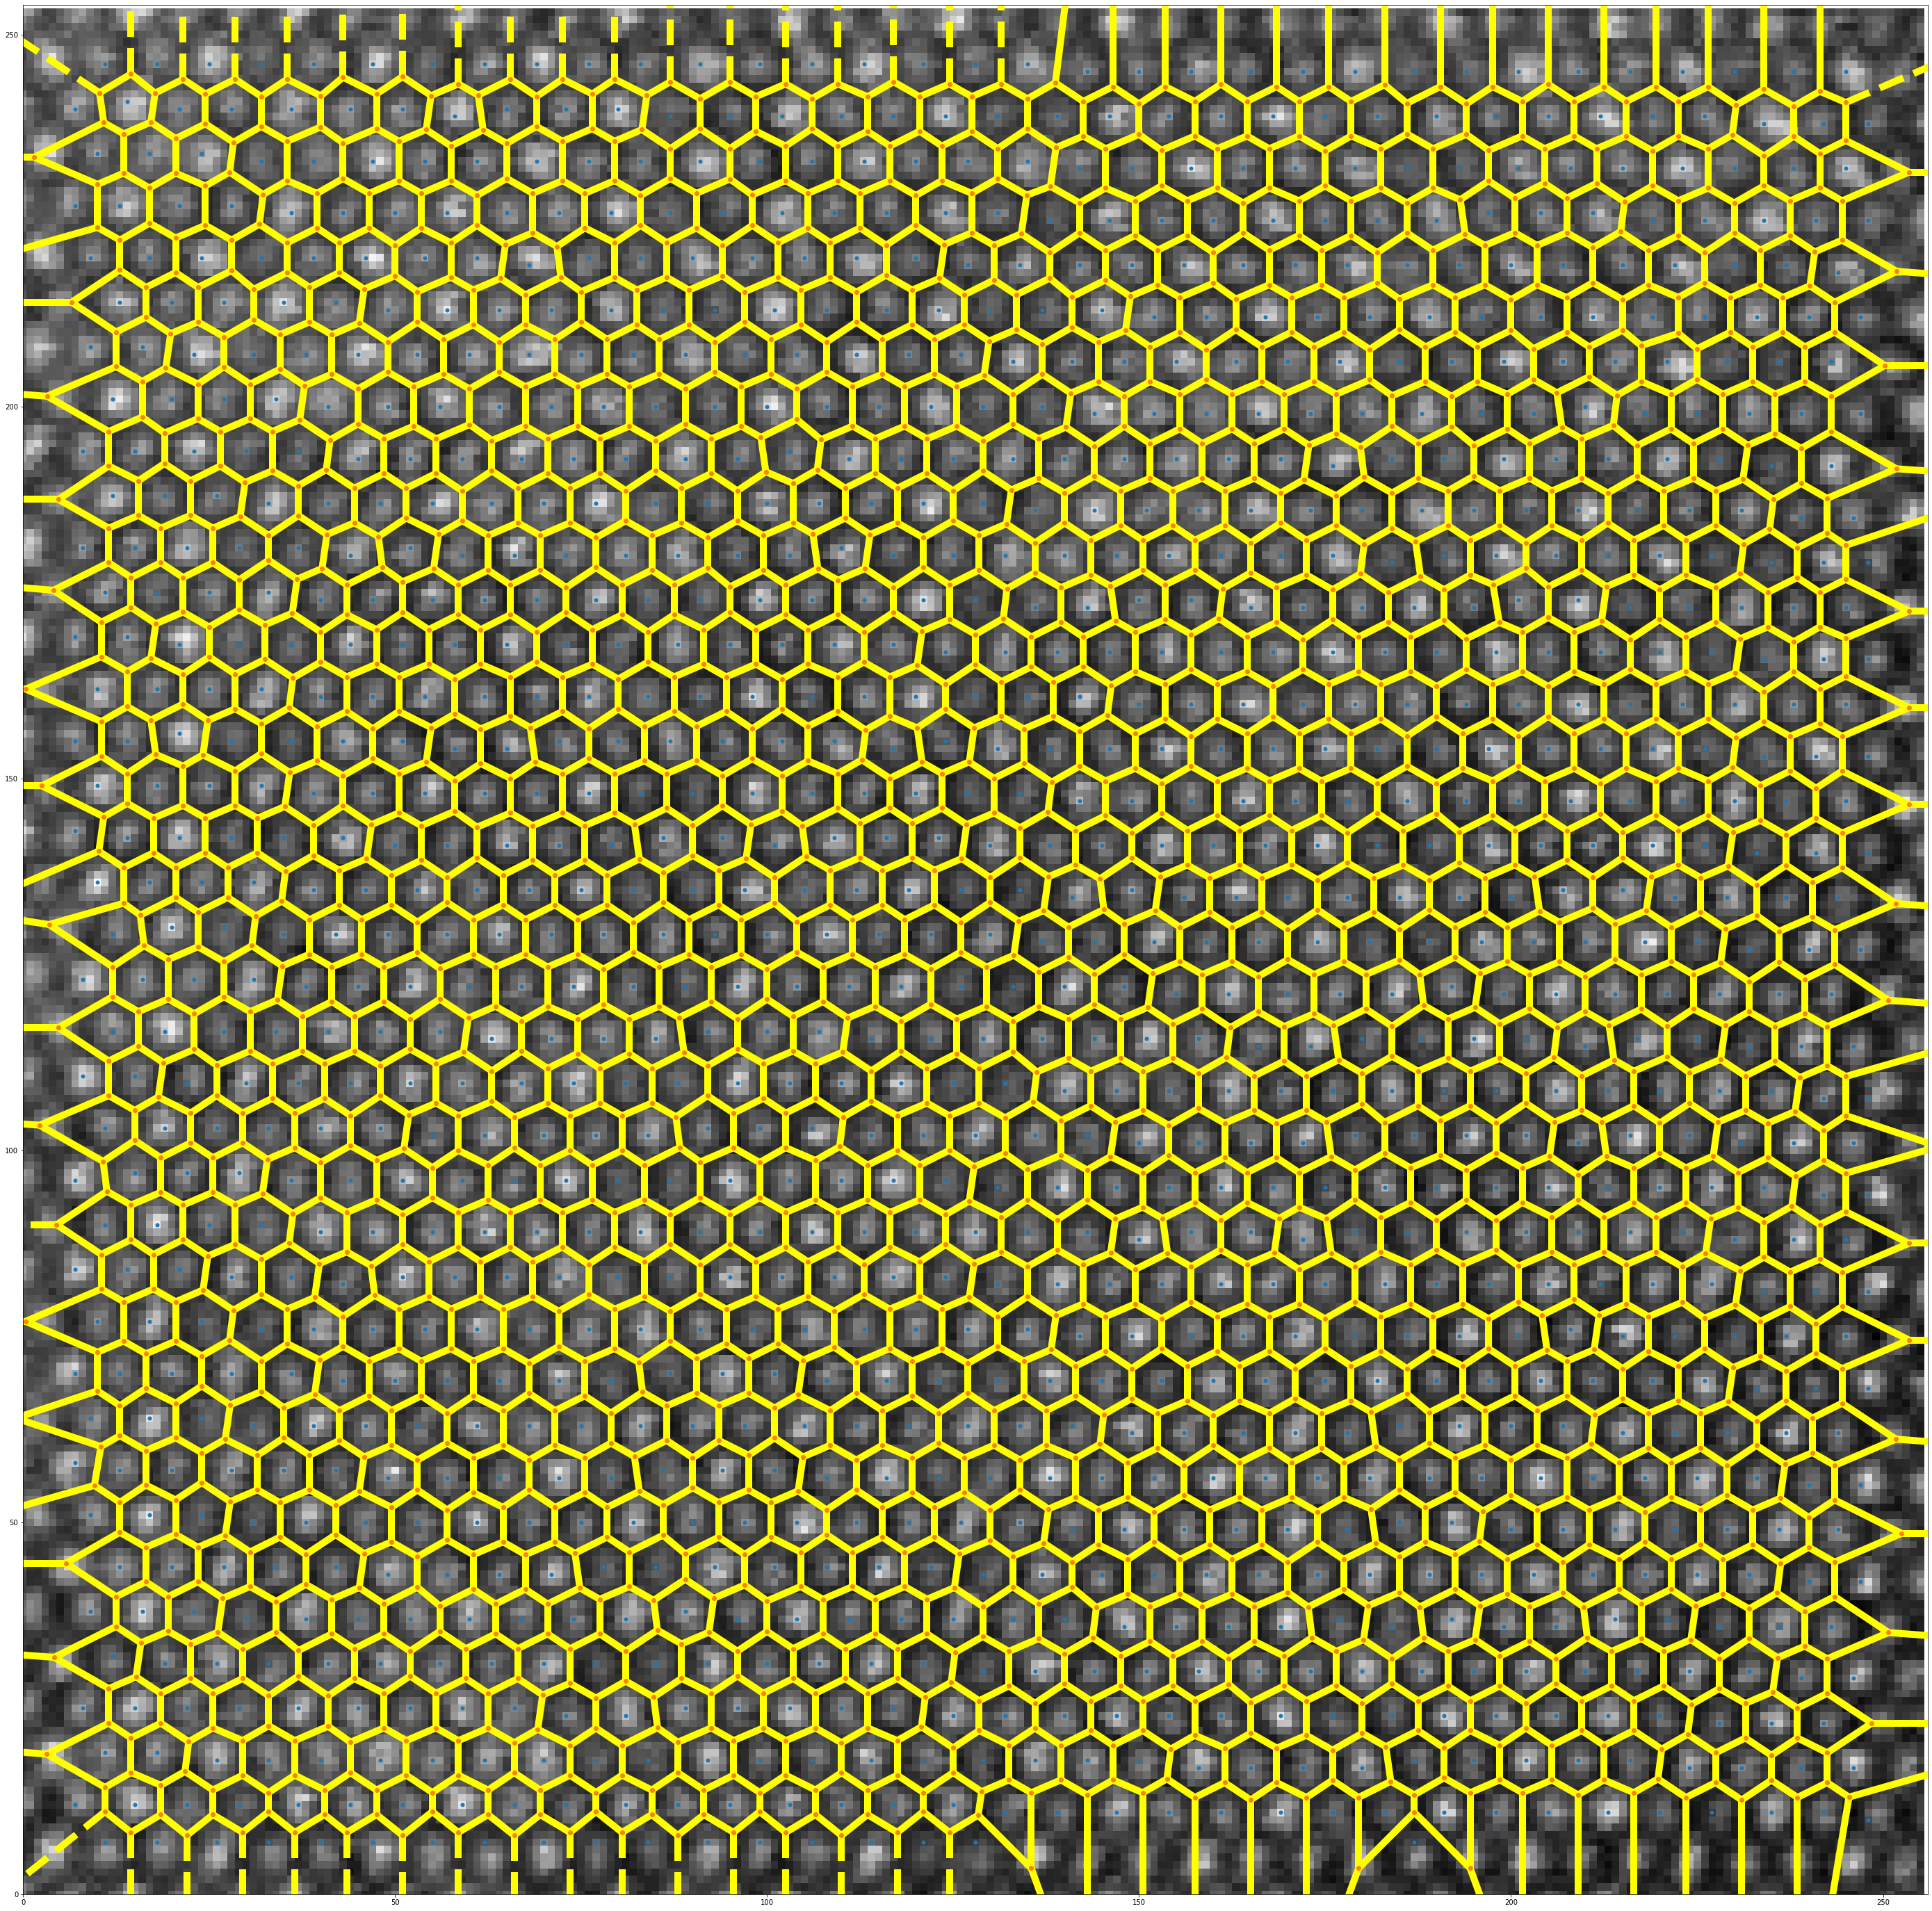

In [30]:
plt.rcParams["figure.figsize"] = (50,50)
fig1, ax1 = plt.subplots()
plt.imshow(ADF, cmap=plt.cm.gray)
voronoi_plot_2d(vor, ax= ax1, show_points=True, show_vertices=True, line_colors='yellow', line_width=10, point_size=10)
plt.xlim((0, ADF.shape[1]))
plt.ylim((0, ADF.shape[0]))
plt.show()

In [31]:
#Then we average the electric field vector in each voronoi cell.
new_x_pos=[]
new_y_pos=[]
new_ex_pos=[]
new_ey_pos=[]
frame_row = ADF.shape[0]
frame_col = ADF.shape[1]
adf_effect = np.zeros(ADF.shape, ADF.dtype)
#pick up the finite region and average inside these regions.
for p1, region in enumerate(vor.point_region):
    if region<0:
        continue
    vertices = vor.regions[region]
    # select the finite region
    if all(v >= 0 for v in vertices):
        #now according to the vertices, determine the
        verti=vor.vertices[vertices]
        min_vals =np.floor(verti.min(0))
        max_vals =np.ceil(verti.max(0))
        if min_vals[0]<0:
            continue
        if min_vals[1]<0:
            continue
        if max_vals[0]>=frame_col:
            continue
        if max_vals[1]>=frame_row:
            continue
        #generate the polygon path
        bbPath = mplPath.Path(verti)
        #generate a list of positions and check if inside the polygon. 
        Y, X = np.mgrid[min_vals[1]:max_vals[1], min_vals[0]:max_vals[0]]
        X_flat = X.flatten()
        Y_flat = Y.flatten()
        positions = np.vstack([X_flat, Y_flat]).T
        effect_positions=bbPath.contains_points(positions)
        #get the index that is true. 
        effect_idx=np.where(effect_positions==True)
        #pay attention of the index.
        ex_array=EX[(np.asarray(Y_flat[effect_idx], dtype=int),np.asarray(X_flat[effect_idx], dtype=int))]
        ey_array=EY[(np.asarray(Y_flat[effect_idx], dtype=int),np.asarray(X_flat[effect_idx], dtype=int))]
        adf_effect[(np.asarray(Y_flat[effect_idx], dtype=int),np.asarray(X_flat[effect_idx], dtype=int))]=1.0
        new_x_pos.append(vor.points[p1, 0])
        new_y_pos.append(vor.points[p1, 1])
        new_ex_pos.append(np.sum(ex_array)/len(effect_idx[0]))
        new_ey_pos.append(np.sum(ey_array)/len(effect_idx[0]))
new_x_pos=np.asarray(new_x_pos)
new_y_pos=np.asarray(new_y_pos)
new_ex_pos=np.asarray(new_ex_pos)
new_ey_pos=np.asarray(new_ey_pos)

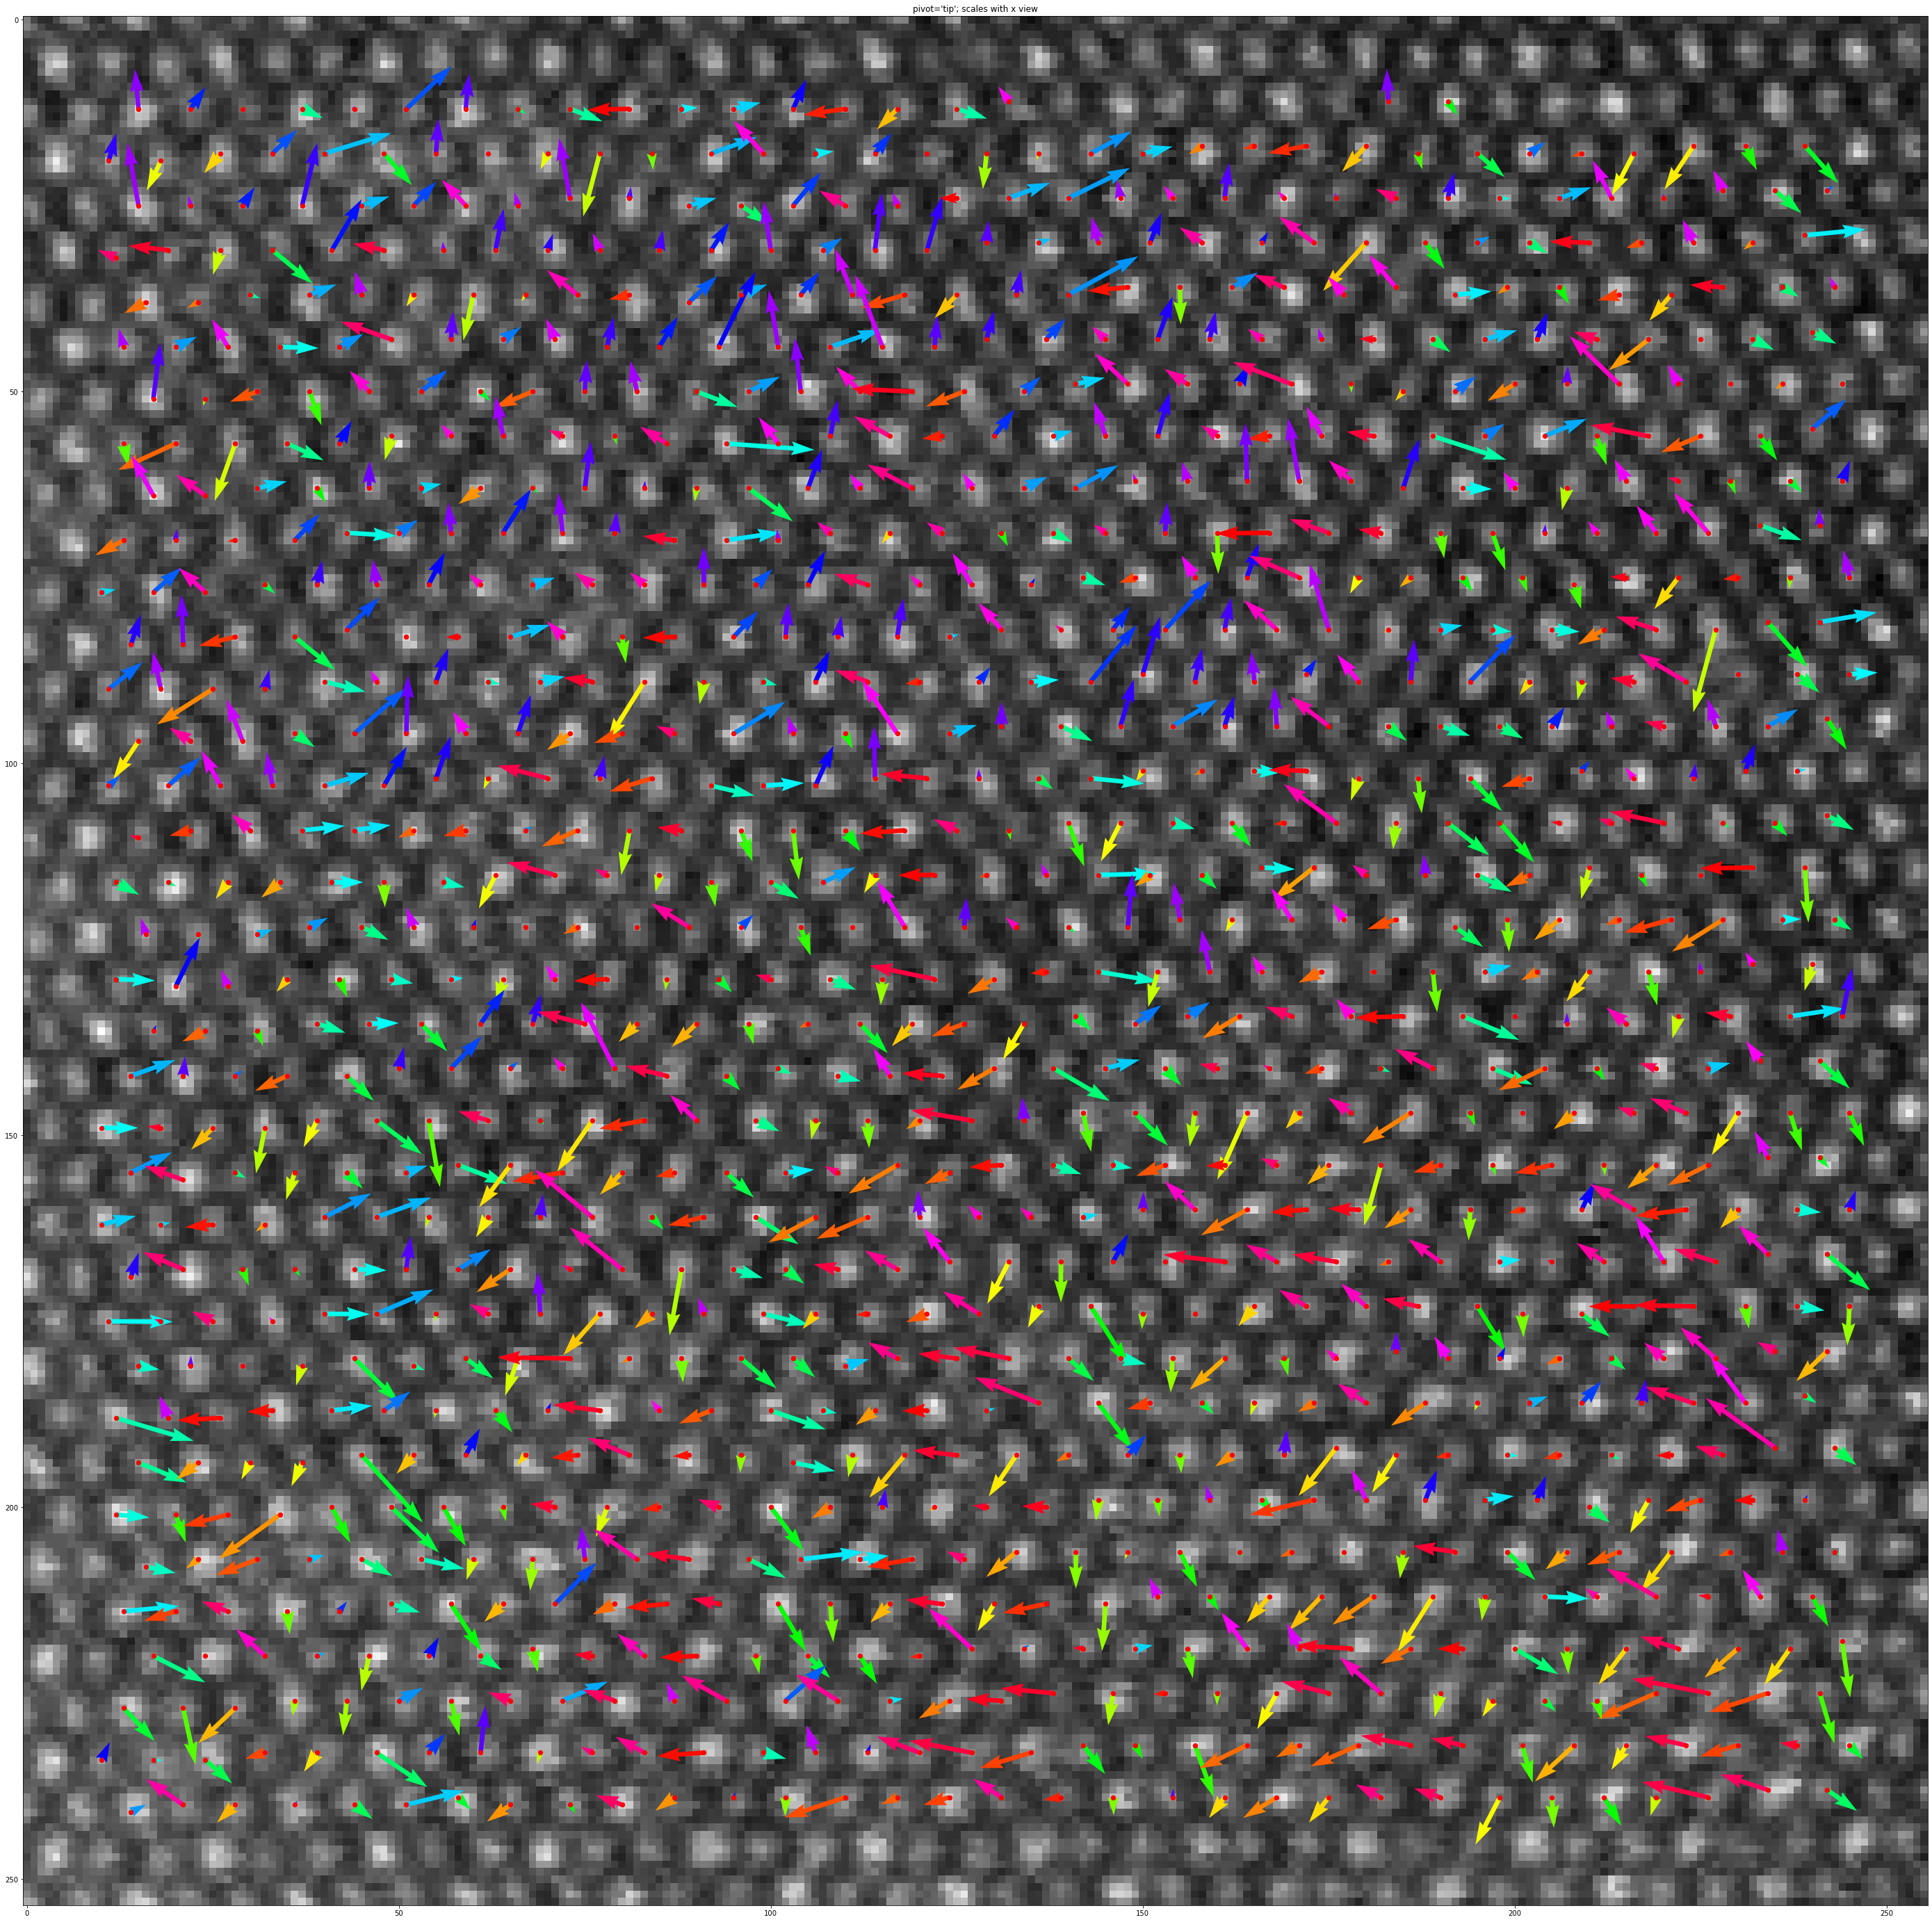

In [32]:
plt.rcParams["figure.figsize"] = (50,50)
fig1, ax1 = plt.subplots()
ax1.set_title("pivot='tip'; scales with x view")
M = np.angle(new_ex_pos+ 1j*new_ey_pos)
Q = ax1.quiver(new_x_pos, new_y_pos, new_ex_pos, new_ey_pos, M, units='x', pivot='tail',cmap=plt.cm.hsv)
qk = ax1.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
ax1.scatter(new_x_pos, new_y_pos, color='r', s=40)
plt.imshow(ADF, cmap=plt.cm.gray)
plt.show()